In [1]:

#imports
from sqlalchemy import create_engine
from datetime import timedelta, datetime, tzinfo
from zipfile import ZipFile
import collections
import pandas as pd
import numpy as np

In [3]:
#read in csvs
states_df = pd.read_csv("all-states-history.csv")

national_df = pd.read_csv("national-history.csv")

In [4]:
states_df.head(10)

,date,state,death,deathConfirmed,deathIncrease,hospitalized,hospitalizedCurrently,positive,positiveIncrease,recovered,totalTestResults,totalTestResultsIncrease
0,3/7/21,AK,305.0,NaN,0,1293.0,33.0,56886.0,0,NaN,1731628.0,0
1,3/7/21,AL,10148.0,7963.0,-1,45976.0,494.0,499819.0,408,295690.0,2323788.0,2347
2,3/7/21,AR,5319.0,4308.0,22,14926.0,335.0,324818.0,165,315517.0,2736442.0,3380
3,3/7/21,AS,0.0,NaN,0,NaN,NaN,0.0,0,NaN,2140.0,0
4,3/7/21,AZ,16328.0,14403.0,5,57907.0,963.0,826454.0,1335,NaN,7908105.0,45110
5,3/7/21,CA,54124.0,NaN,258,NaN,4291.0,3501394.0,3816,NaN,49646014.0,133186
6,3/7/21,CO,5989.0,5251.0,3,23904.0,326.0,436602.0,840,NaN,6415123.0,38163
7,3/7/21,CT,7704.0,6327.0,0,12257.0,428.0,285330.0,0,NaN,6520366.0,0
8,3/7/21,DC,1030.0,NaN,0,NaN,150.0,41419.0,146,29570.0,1261363.0,5726
9,3/7/21,DE,1473.0,1337.0,9,NaN,104.0,88354.0,215,NaN,1431942.0,5867


In [5]:
national_df.head()

,date,death,deathIncrease,hospitalizedIncrease,hospitalizedCurrently,hospitalizedCumulative,negative,negativeIncrease,positive,positiveIncrease,totalTestResults,totalTestResultsIncrease
0,3/7/21,515148.0,839,726,40212.0,878613.0,74582825.0,131835,28756184.0,41530,363824818,1169754
1,3/6/21,514309.0,1680,503,41401.0,877887.0,74450990.0,143835,28714654.0,60015,362655064,1430992
2,3/5/21,512629.0,2221,2781,42541.0,877384.0,74307155.0,271917,28654639.0,68787,361224072,1744417
3,3/4/21,510408.0,1743,1530,44172.0,874603.0,74035238.0,177957,28585852.0,65487,359479655,1590984
4,3/3/21,508665.0,2449,2172,45462.0,873073.0,73857281.0,267001,28520365.0,66836,357888671,1406795


KeyError: 'date'

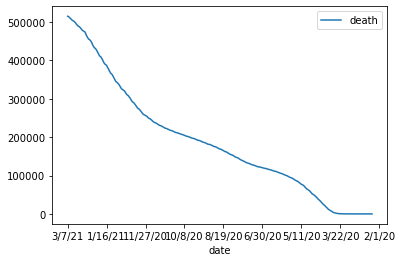

In [5]:
death = national_df.plot.line(x='date', y='death')

#we can loc for the past 3 months
date_df = national_df.set_index('date')
date_df.sort_values(by=['date'], inplace=True, ascending=False)
monthtrend_df = date_df.loc['01/01/21':'3/7/21']

trend=monthtrend_df.plot.line(x='date', y='death')


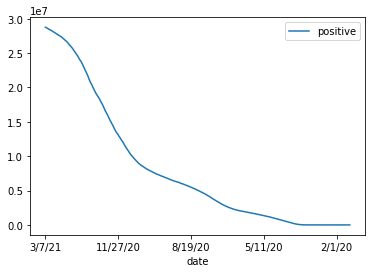

In [50]:
positive=national_df.plot.line(x='date', y='positive')

In [51]:
connection_string = "postgres:Osram919267%@localhost:5432/Covid19_Project2"
engine = create_engine(f'postgresql://{connection_string}')

In [52]:
#engine.table_names()

In [53]:
# michigan_df = states_df.loc[states_df['state'] == "MI", :]

# michigan_df

In [54]:
import psycopg2
import pandas as pd
import os
from io import StringIO
import sys

pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 1000)
pd.set_option('display.width', 1000)
param_dic = {
    "host"      : "localhost",
    "database"  : "Covid19_Project2",
    "user"      : "postgres",
    "password"  : "Osram919267%"
}
db_url = {'drivername': 'postgresql+psycopg2',
        'username': 'postgres',
        'password': 'Osram919267%',
        'host': 'localhost',
        'port': 5432,
        'database': 'Covid19_Project2'
}
def connect(params_dic):
    '''Connect to the PostgreSQL database server'''
    conn = None
    try:
        # connect to the PostgreSQL server
        print('Connecting to the PostgreSQL database...')
        conn = psycopg2.connect(**params_dic)
    except (Exception, psycopg2.DatabaseError) as error:
        print(error)
        print("Connection not successful!")
        sys.exit(1)
    print("Connection Successful!")
    return conn
def execute_query(conn, query):
    """ Execute a single query """
    ret = 0 # Return value
    cursor = conn.cursor()
    try:
        cursor.execute(query)
        conn.commit()
    except (Exception, psycopg2.DatabaseError) as error:
        print("Error: %s" % error)
        conn.rollback()
        cursor.close()
        return 1
    # If this was a select query, return the result
    if 'select' in query.lower():
        ret = cursor.fetchall()
    cursor.close()
    return ret
def open_as_df(query,conn):
    '''pass query to get dataframe: select * from "5_min" '''
    try:
        df = pd.read_sql_query(sql = query,con = conn, index_col= ['date'])
    except (Exception, psycopg2.DatabaseError) as error:
        print(error)
        sys.exit(1)
    conn.close()
    return df
def copy_table_schema(existing_tb, new_tb):
    from sqlalchemy import create_engine, MetaData, Table
    from sqlalchemy.engine.url import URL
    engine = create_engine(URL(**db_url))
    engine._metadata = MetaData(bind=engine)
    engine._metadata.reflect(engine)
    sch_Table = Table(existing_tb, engine._metadata)
    new_Table = Table(new_tb, engine._metadata)
    # copy schema and create newTable from oldTable
    for column in sch_Table.columns:
        new_Table.append_column(column.copy())
    new_Table.create()
def copy_to_db(conn, df, table):
    """
    save the dataframe in memory and use copy_from() to copy it to the table in the db
    """
    # save dataframe to an object in memory buffer
    buffer = StringIO()
    df.to_csv(buffer, header=False, index = False)
    buffer.seek(0)
    cursor = conn.cursor()
    try:
        cursor.copy_from(buffer, table, sep=",")
        conn.commit()
    except (Exception, psycopg2.DatabaseError) as error:
        print("Error: %s" % error)
        conn.rollback()
        cursor.close()
        return 1
    print("Done!")
    cursor.close()
    conn.close()

In [55]:
execute_query(connect(param_dic), "select * from state_history;")

Connecting to the PostgreSQL database...
Connection Successful!


[(datetime.date(2021, 3, 7),
  'AK',
  305,
  None,
  0,
  1293,
  33,
  56886,
  0,
  None,
  1731628,
  0),
 (datetime.date(2021, 3, 7),
  'AL',
  10148,
  7963,
  -1,
  45976,
  494,
  499819,
  408,
  295690,
  2323788,
  2347),
 (datetime.date(2021, 3, 7),
  'AR',
  5319,
  4308,
  22,
  14926,
  335,
  324818,
  165,
  315517,
  2736442,
  3380),
 (datetime.date(2021, 3, 7),
  'AS',
  0,
  None,
  0,
  None,
  None,
  0,
  0,
  None,
  2140,
  0),
 (datetime.date(2021, 3, 7),
  'AZ',
  16328,
  14403,
  5,
  57907,
  963,
  826454,
  1335,
  None,
  7908105,
  45110),
 (datetime.date(2021, 3, 7),
  'CA',
  54124,
  None,
  258,
  None,
  4291,
  3501394,
  3816,
  None,
  49646014,
  133186),
 (datetime.date(2021, 3, 7),
  'CO',
  5989,
  5251,
  3,
  23904,
  326,
  436602,
  840,
  None,
  6415123,
  38163),
 (datetime.date(2021, 3, 7),
  'CT',
  7704,
  6327,
  0,
  12257,
  428,
  285330,
  0,
  None,
  6520366,
  0),
 (datetime.date(2021, 3, 7),
  'DC',
  1030,
  None,
  0,


In [56]:
connect(param_dic)

Connecting to the PostgreSQL database...
Connection Successful!


<connection object at 0x0000016BC3A186A0; dsn: 'user=postgres password=xxx dbname=Covid19_Project2 host=localhost', closed: 0>

In [15]:
connection_string = "postgres:Osram919267%@localhost:5432/ETL_Project"
engine = create_engine(f'postgresql://{connection_string}')

In [16]:
df = open_as_df("select * from national_history;", connect(param_dic))

Connecting to the PostgreSQL database...
Connection Successful!


In [57]:
df # need to drop NaN and 0 values from column 'date'

,death,deathincrease,hospitalezedincrease,hospitalizedcurrently,hospitalizedcumulative,negative,negativeincrease,positive,positiveincrease,totaltestresults,totaltestresultsincrease
date,,,,,,,,,,,
2021-03-07,515148.0,839,726,40212.0,878613.0,74582825.0,131835,28756184.0,41530,363824818,1169754
2021-03-06,514309.0,1680,503,41401.0,877887.0,74450990.0,143835,28714654.0,60015,362655064,1430992
2021-03-05,512629.0,2221,2781,42541.0,877384.0,74307155.0,271917,28654639.0,68787,361224072,1744417
2021-03-04,510408.0,1743,1530,44172.0,874603.0,74035238.0,177957,28585852.0,65487,359479655,1590984
2021-03-03,508665.0,2449,2172,45462.0,873073.0,73857281.0,267001,28520365.0,66836,357888671,1406795
2021-03-02,506216.0,1728,1871,46388.0,870901.0,73590280.0,255779,28453529.0,54248,356481876,1343519
2021-03-01,504488.0,1241,1024,46738.0,869030.0,73334501.0,118077,28399281.0,48092,355138357,1154440
2021-02-28,503247.0,1051,879,47352.0,868006.0,73216424.0,203599,28351189.0,54349,353983917,1408422
2021-02-27,502196.0,1847,1428,48871.0,867127.0,73012825.0,205090,28296840.0,71245,352575495,1655179


In [58]:
df2 = open_as_df("select * from state_history;", connect(param_dic))

Connecting to the PostgreSQL database...
Connection Successful!


In [59]:
#df2

In [60]:
states = df2.groupby(['state', 'death']).sum()
deathState = round(states.groupby(['state']).mean(),0)
deathState.head()

,deathconfirmed,deathincrease,hospitalized,hospitalizedcurrently,positive,positiveincrease,recovered,totaltestresults,totaltestresultsincrease
state,,,,,,,,,
AK,127.0,3.0,1383.0,156.0,54019.0,499.0,4231.0,1826471.0,15190.0
AL,2859.0,32.0,19534.0,1290.0,197647.0,1592.0,100896.0,1166489.0,7401.0
AR,1513.0,17.0,6509.0,607.0,121362.0,1047.0,109186.0,1188823.0,8825.0
AS,0.0,0.0,0.0,0.0,0.0,0.0,0.0,444489.0,2140.0
AZ,5122.0,49.0,22233.0,1919.0,285821.0,2474.0,0.0,2751572.0,23676.0


In [61]:
#deathState.rename(columns = {'state' : 'STUSPS'}, inplace = True)


In [62]:
import matplotlib.pyplot as plt
import geopandas

In [63]:
states2 = geopandas.read_file('2018_shapefile/cb_2018_us_state_500k.shp')
type(states2)

geopandas.geodataframe.GeoDataFrame

In [64]:
states2.head()

,STATEFP,STATENS,AFFGEOID,GEOID,STUSPS,NAME,LSAD,ALAND,AWATER,geometry
0,28,01779790,0400000US28,28,MS,Mississippi,00,121533519481,3926919758,"MULTIPOLYGON (((-88.50297 30.21523, -88.49176 ..."
1,37,01027616,0400000US37,37,NC,North Carolina,00,125923656064,13466071395,"MULTIPOLYGON (((-75.72681 35.93584, -75.71827 ..."
2,40,01102857,0400000US40,40,OK,Oklahoma,00,177662925723,3374587997,"POLYGON ((-103.00257 36.52659, -103.00219 36.6..."
3,51,01779803,0400000US51,51,VA,Virginia,00,102257717110,8528531774,"MULTIPOLYGON (((-75.74241 37.80835, -75.74151 ..."
4,54,01779805,0400000US54,54,WV,West Virginia,00,62266474513,489028543,"POLYGON ((-82.64320 38.16909, -82.64300 38.169..."


In [66]:
bothdf = [deathState,states2]
df_combined = pd.concat(bothdf, keys=['state', 'STUSPS'])
df_combined.head() # need to fix Nan values for states2 df

deathconfirmed  deathincrease  hospitalized  hospitalizedcurrently  positive  positiveincrease  recovered  totaltestresults  totaltestresultsincrease STATEFP STATENS AFFGEOID GEOID STUSPS NAME LSAD  ALAND  AWATER geometry
state AK           127.0            3.0        1383.0                  156.0   54019.0             499.0     4231.0         1826471.0                   15190.0     NaN     NaN      NaN   NaN    NaN  NaN  NaN    NaN     NaN     None
      AL          2859.0           32.0       19534.0                 1290.0  197647.0            1592.0   100896.0         1166489.0                    7401.0     NaN     NaN      NaN   NaN    NaN  NaN  NaN    NaN     NaN     None
      AR          1513.0           17.0        6509.0                  607.0  121362.0            1047.0   109186.0         1188823.0                    8825.0     NaN     NaN      NaN   NaN    NaN  NaN  NaN    NaN     NaN     None
      AS             0.0            0.0           0.0                    0.0       0.0               0.0        0.0          444489.0                    2140.0     NaN     NaN      NaN   NaN    NaN  NaN  NaN    NaN     NaN     None
      AZ          5122.0           49.0       22233.0                 1919.0  285821.0            2474.0        0.0         2751572.0                   23676.0     NaN     NaN      NaN   NaN    NaN  NaN  NaN    NaN     NaN     None

In [67]:
states2.crs

<Geographic 2D CRS: EPSG:4269>
Name: NAD83
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: North America - NAD83
- bounds: (167.65, 14.92, -47.74, 86.46)
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [68]:
states2 = states2.to_crs("EPSG:3395")

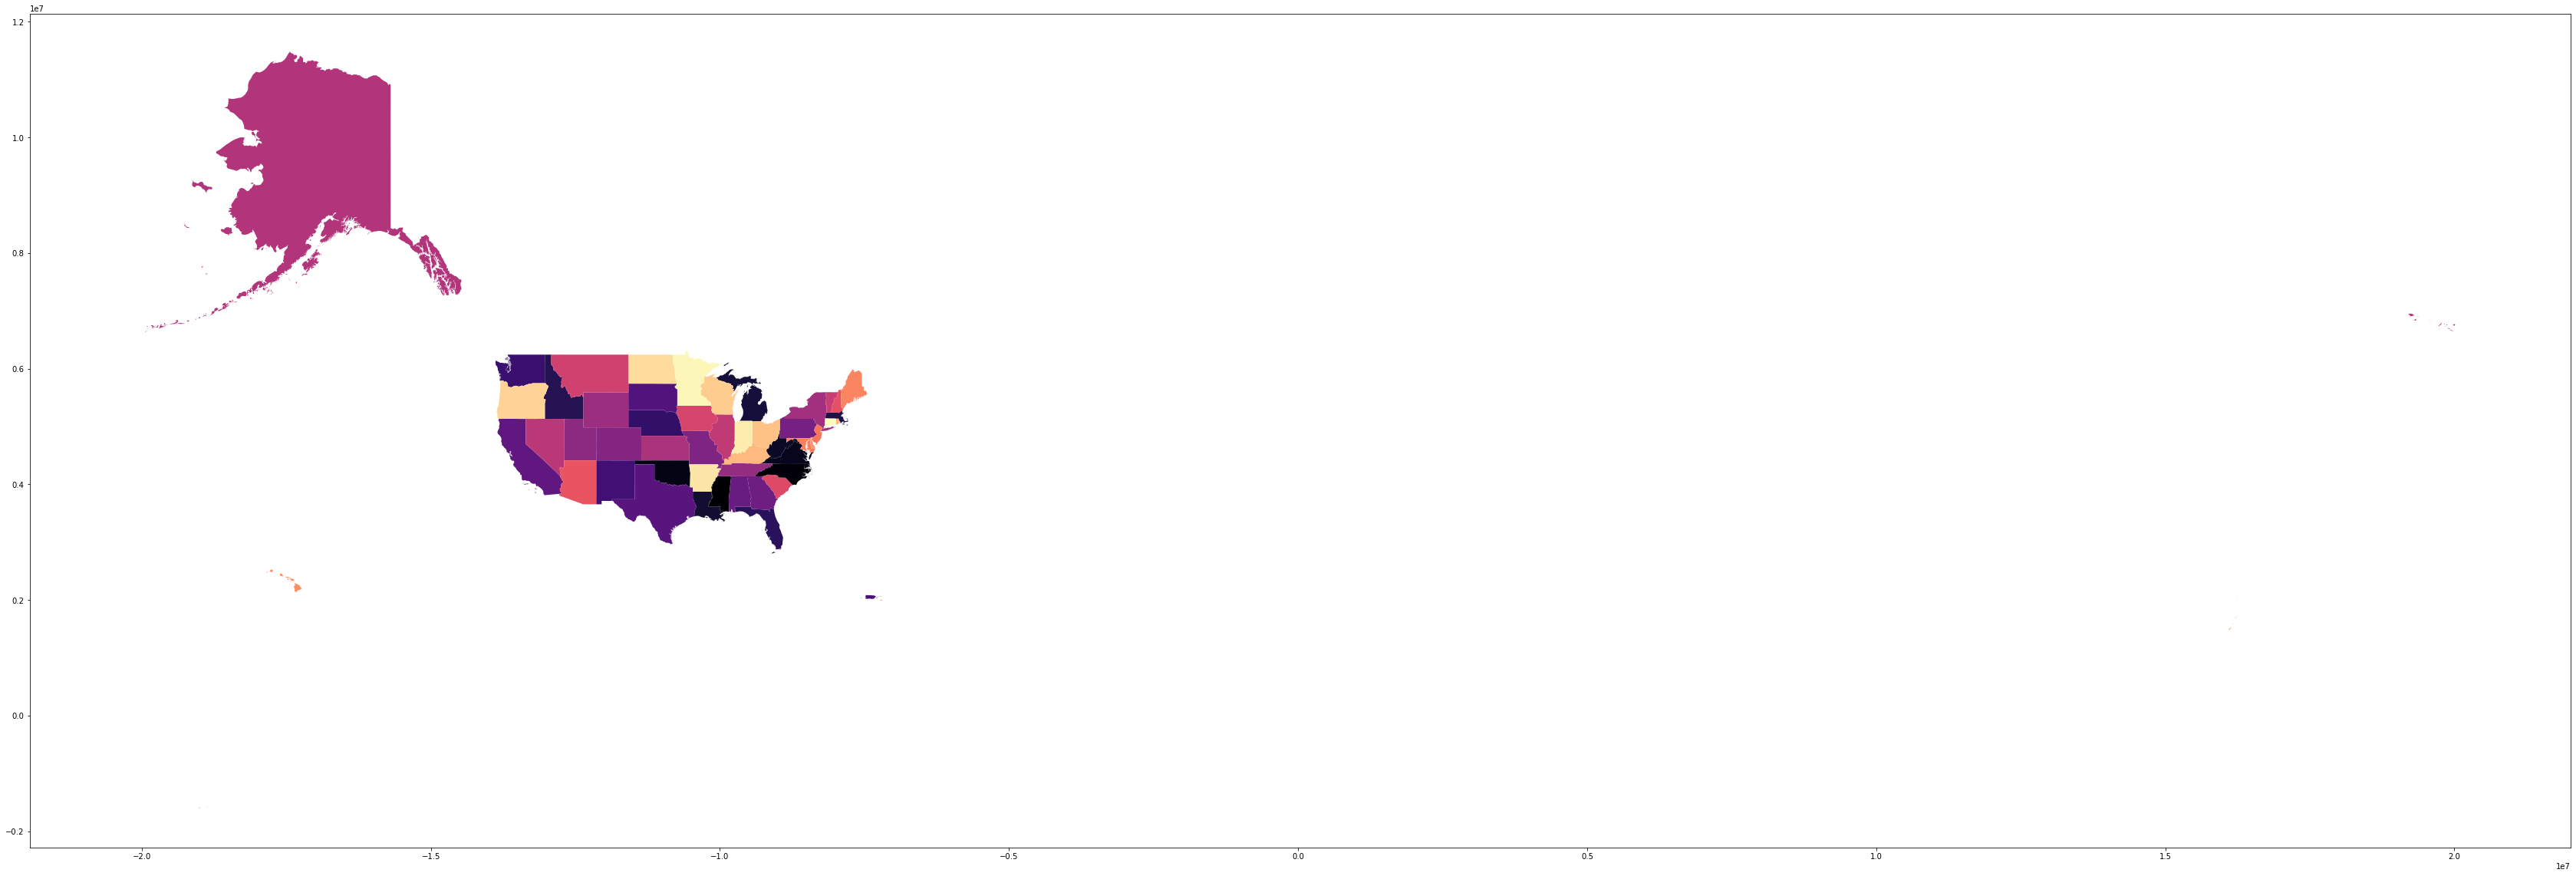

In [69]:
states2.plot(cmap='magma', figsize=(60, 20))
plt.show()  # plot again after merge is complted on #35